# **The Heston Stochastic Volatility Model**
We will here do our final calculations for the numerical results part of the thesis. The hyper-parameter tuning and building the model has been done in subsequent notebooks

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

We will start by importing the nessecary packages

In [2]:
import math
import pandas as pd
import datetime, os
import numpy as np
import numpy.random as npr
from pylab import plt, mpl

import threading

import time
import timeit

from scipy.stats import norm
from scipy import optimize
import scipy.integrate as integrate
import scipy.special as special 

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

In [3]:
'''import sys
!{sys.executable} -m pip install git+https://github.com/tensorflow/docs''';

In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

Open the dataframe as a CSV.

In [5]:
#To read the import the csv-file, use:
raw_Options_input_train = pd.read_csv (r"/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_data_input_deep_train.csv")
raw_Options_output_train = pd.read_csv (r"/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_data_output_deep_train.csv")
raw_Options_input_test = pd.read_csv (r"/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_data_input_deep_test.csv")
raw_Options_output_test = pd.read_csv (r"/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_data_output_deep_test.csv")
raw_Options_input_test_wide = pd.read_csv (r"/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_data_input_deep_test_wide.csv")
raw_Options_output_test_wide = pd.read_csv (r"/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_data_output_deep_test_wide.csv")



#Creates some unnamed column in the beginning, delete it:
del raw_Options_input_train['Unnamed: 0']
del raw_Options_output_train['Unnamed: 0']
del raw_Options_input_test['Unnamed: 0']
del raw_Options_output_test['Unnamed: 0']
del raw_Options_input_test_wide['Unnamed: 0']
del raw_Options_output_test_wide['Unnamed: 0']


In [6]:
Options_input_train = raw_Options_input_train.copy()
Options_output_train = raw_Options_output_train.copy()
Options_input_test = raw_Options_input_test.copy()
Options_output_test = raw_Options_output_test.copy()
Options_input_test_wide = raw_Options_input_test_wide.copy()
Options_output_test_wide = raw_Options_output_test_wide.copy()

### **Data preparation**

We have, unlike for the ANN already split the data-sets into training and testing. The training data-set is twice the size of the ANN and so is the test data-set. however, in order to compare the testing of the ANN to the DNN directly, we reduce the test data-set to the same size as for the ANN (in reality when checking the speed, we could just calculate the speed per one smile).

In [7]:
train_dataset = Options_input_train
test_dataset = Options_input_test.sample(frac=0.5, random_state=42)
test_dataset_wide = Options_input_test_wide.sample(frac=0.5, random_state=42)

train_labels = Options_output_train
test_labels = Options_output_test.sample(frac=0.5, random_state=42)
test_labels_wide = Options_output_test_wide.sample(frac=0.5, random_state=42)

Check the overall statistics

In [8]:
train_stats = train_dataset.describe().T
test_stats = test_dataset.describe().T
test_stats_wide = test_dataset_wide.describe().T

Separate the target values from the input values. These values are the values that we will train the model to predict. We will also normalize the data due to reasons described in the thesis

In [9]:
#normalize the data
def norm(x):
    return (x - train_stats['min']) / (train_stats['max']-train_stats['min'])
normed_train_data = norm(train_dataset).values

def norm_test(x):
    return (x - train_stats['min']) / (train_stats['max']-train_stats['min'])
normed_test_data = norm_test(test_dataset).values

def norm_test_wide(x):
    return (x - train_stats['min']) / (train_stats['max']-train_stats['min'])
normed_test_data_wide = norm_test_wide(test_dataset_wide).values

#make the labels into numpy array just like the normed training data
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)
test_labels_wide = np.asarray(test_labels_wide)

#check the shapes
print("Input train data:", normed_train_data.shape, " Output train data:", train_labels.shape)
print("Input test data:", normed_test_data.shape, " Output test data:", test_labels.shape)
print("Input test data:", normed_test_data_wide.shape, " Output test data:", test_labels_wide.shape)

Input train data: (598954, 7)  Output train data: (598954, 10)
Input test data: (9998, 7)  Output test data: (9998, 10)
Input test data: (9976, 7)  Output test data: (9976, 10)


## **The model**

Now let's build the neural network with one hidden layer using tensorflow and a Sequential API.

Note: This model has been primarily chosen based on the same hyperparameters as in McGhee's paper. We have also done hyper-parameter tuning in some of the other notebooks in order to find out which hyper-parameters fits out data the best.

In [10]:
input_size = len(train_dataset.keys())
output_size = 10
hidden_layer_size = 400

#weight and bias initializers
weights_initializer = keras.initializers.GlorotUniform(seed=42)
bias_initializer = keras.initializers.Zeros()

def build_model():
    model = keras.models.Sequential([
            #Layer to be used as an entry point into a Network
            keras.layers.InputLayer(input_shape=[len(train_dataset.keys())]),
        
            #Dense layer 1
            keras.layers.Dense(hidden_layer_size, activation='relu', kernel_initializer = weights_initializer,
                               bias_initializer = bias_initializer, name='Layer_1'),
            #Dense layer 2
            keras.layers.Dense(hidden_layer_size, activation='relu', kernel_initializer = weights_initializer,
                               bias_initializer = bias_initializer, name='Layer_2'),
            #Dense layer 3
            keras.layers.Dense(hidden_layer_size, activation='relu', kernel_initializer = weights_initializer,
                               bias_initializer = bias_initializer, name='Layer_3'),
            #Dense layer 4
            keras.layers.Dense(hidden_layer_size, activation='relu', kernel_initializer = weights_initializer,
                               bias_initializer = bias_initializer, name='Layer_4'),
        
            #Output layer. Activation function is linear since we are doing regression
            keras.layers.Dense(output_size, activation='linear', name='Output_layer')
                                ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999,
                             epsilon=1e-07, amsgrad=False, name='Adam')
    
    #Compiling the model
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error', #Computes the mean of squares of errors between labels and predictions
                  metrics=['mean_squared_error']) #Computes the mean squared error between y_true and y_pred

    return model

In [11]:
model = build_model()

Inspect the model using .summary to get a simple description of the model (there should be no non-trainable parameters)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_1 (Dense)              (None, 400)               3200      
_________________________________________________________________
Layer_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
Layer_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
Layer_4 (Dense)              (None, 400)               160400    
_________________________________________________________________
Output_layer (Dense)         (None, 10)                4010      
Total params: 488,410
Trainable params: 488,410
Non-trainable params: 0
_________________________________________________________________


Now, try out the model. Take a batch of 10 examples from the training data and call model.predict on it. There should be no NaN, otherwise something is wrong

In [13]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.01963972,  0.01374625, -0.00493291, -0.00256385,  0.0090208 ,
        -0.0603289 ,  0.03900418,  0.00428688,  0.03751598, -0.0479023 ],
       [-0.00697349,  0.02837318,  0.01808466, -0.00298797, -0.01468647,
        -0.09624939,  0.04254852, -0.00220664,  0.02003854, -0.05219425],
       [-0.00528921,  0.01693806,  0.00414245, -0.01105901,  0.06748834,
        -0.07053617,  0.04783759,  0.03041759,  0.01219922, -0.07637467],
       [ 0.00018525,  0.01853941,  0.01528622, -0.00083739,  0.00580428,
        -0.04842255,  0.03747198,  0.007662  ,  0.01129742, -0.04423824],
       [ 0.01121589,  0.00115996, -0.00553195,  0.01080052,  0.02539448,
        -0.03600194,  0.02596275, -0.00518655,  0.00668481, -0.02421531],
       [-0.01260628,  0.0118151 ,  0.02214932, -0.00329084, -0.01555848,
        -0.03126774,  0.0235371 ,  0.01355147,  0.01752073, -0.04941883],
       [ 0.0067571 ,  0.00225034,  0.02732112,  0.02839946,  0.01181355,
        -0.0461827 ,  0.02647154,  0.00488405

Train the model for #max_epochs epochs, and record the training and validation accuracy in the history object.

In [14]:
%%time

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

batch_size = 32
max_epochs = 1000000000

#Stop training if the val_loss has not improved over the last #number of epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=100)

#log our training in order to display it to tensorboard (provides great visual effects)
NAME = "Heston_Tensorboard-{}".format(int(time.time()))
tensorboard_callback = TensorBoard(log_dir="logs/fit/{}".format(NAME), histogram_freq=1)

#Initialize TimeStopping callback 
time_stopping_callback = tfa.callbacks.TimeStopping(seconds=12*60*60, verbose=1)

#Model checkpoint (save the best weights and biases) (change monitor to 'mean_squared_error')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="logs/fit/weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                    monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='min', save_freq='epoch', options=None)

#fit the model and save it under history
history = model.fit(normed_train_data, train_labels, 
         batch_size=batch_size, 
         epochs=max_epochs,
         validation_split=0.08,
         verbose=0,
         callbacks=[early_stopping, PrintDot(), time_stopping_callback, tensorboard_callback])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..............................CPU times: user 1d 1h 4min 47s, sys: 1h 50min 11s, total: 1d 2h 54min 58s
Wall time: 10h 5min 4s


In [15]:
%tensorboard --logdir logs/fit

Visualize the model's training progress using the stats stored in the history object.

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_squared_error,val_loss,val_mean_squared_error,epoch
525,6.320779e-08,6.320779e-08,9.637245e-08,9.637245e-08,525
526,6.210959e-08,6.210959e-08,7.076292e-08,7.076292e-08,526
527,6.373855e-08,6.373855e-08,1.028696e-07,1.028696e-07,527
528,6.302156e-08,6.302156e-08,1.536473e-07,1.536473e-07,528
529,6.337373e-08,6.337373e-08,1.034997e-07,1.034997e-07,529


## **Visualization**

Inspirations:
- https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/GaussianProcess
- https://www.kite.com/python/answers/how-to-plot-on-a-log-scale-with-matplotlib-in-python
- https://stackoverflow.com/questions/60683901/tensorboard-smoothing

Make a simple plot of the training (there is no need for this as tensorboard does it already, but still great visualizer for printing)

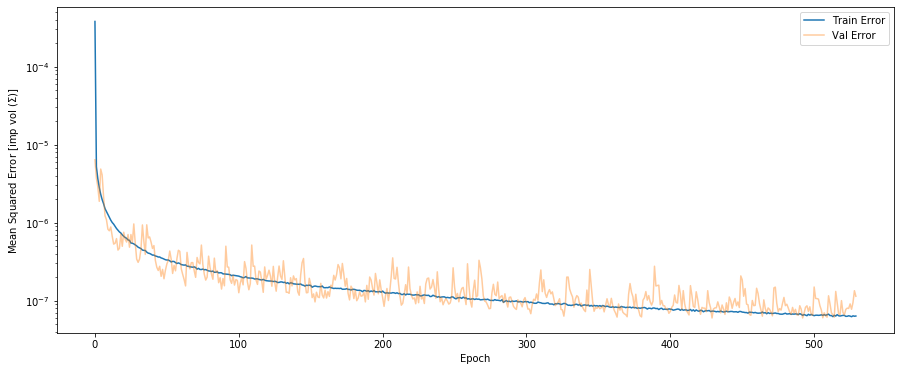

In [17]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure(figsize=(15, 6))
  plt.yscale("log")
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error [imp vol ($\Sigma$)]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'].ewm(com=0.5).mean(),
           label = 'Val Error', alpha=0.4)
  plt.legend()
  
  #plt.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_mse.png',bbox_inches='tight')

  plt.show()


plot_history(history)



The graph shows that on the validation set, the average error is usually around +/- 7e-08

Let's see how well the model generalizes by using the test set, which we did not use when training the model. This tells us how well we can expect the model to predict when we use it in the real world (we print the mean_squared_error).

In [18]:
loss, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Squared Error: {:5.10f} imp vol".format(mse))

Testing set Mean Squared Error: 0.0000000760 imp vol


## **ERROR DISTRIBUTION**

- https://www.tensorflow.org/tutorials/keras/regression

In [19]:
import matplotlib.ticker as mtick

Finally, predict the implied volatility values using data in the testing set

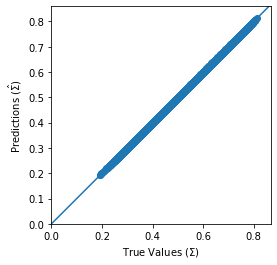

In [20]:
test_predictions = model.predict(normed_test_data).flatten(order="C")
test_labelz = test_labels.flatten(order="C")

plt.scatter(test_labelz, test_predictions)
plt.xlabel(r'True Values ($\Sigma$)')
plt.ylabel(r'Predictions ($\hat{\Sigma}$)')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

It looks like our model predicts really well. Let's take a look at the error distribution.

### Distribution of prediction errors

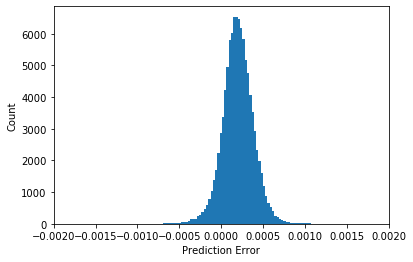

In [21]:
error = test_predictions - test_labelz
plt.hist(error, bins = 200)
plt.xlim(-0.002, 0.002)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

Almost perfect gaussian distribution.

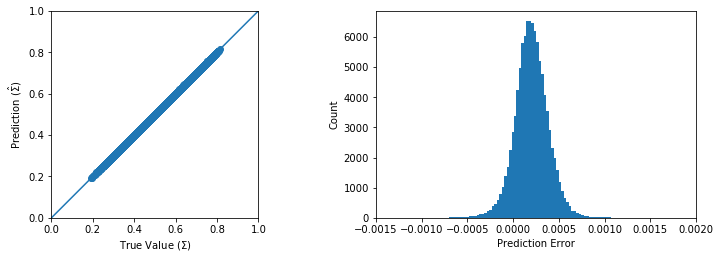

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
fig.tight_layout(pad=3.0)


ax1.scatter(test_labels, test_predictions)
ax1.set_xlabel(r'True Value ($\Sigma$)')
ax1.set_ylabel(r'Prediction ($\hat{\Sigma}$)')
ax1.axis('equal')
ax1.axis('square')
ax1.set_xlim([0,plt.xlim()[1]])
ax1.set_ylim([0,plt.xlim()[1]])
ax1.plot([-100, 100], [-100, 100])

ax2.hist(error, bins = 200)
ax2.set_xlim(-0.0015, 0.002)
ax2.set_xlabel("Prediction Error")
ax2.set_ylabel("Count");

#fig.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_errordist.png',bbox_inches='tight')


### Plots like in Lie et al.
Lets make ad plot as the one in Liu et al. (page 15):

The density / y-axis is the relative frequency density and the distribution / other y-axis is the cumulative distribution

Links:
- relative frequency: https://www.khanacademy.org/math/ap-statistics/density-curves-normal-distribution-ap/density-curves/v/density-curves
- weights making the relative freqency: https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.hist.html and https://stackoverflow.com/questions/9767241/setting-a-relative-frequency-in-a-matplotlib-histogram
- R Squared definition: https://www.investopedia.com/terms/r/r-squared.asp#:~:text=To%20calculate%20the%20total%20variance,you%20have%20the%20R%2Dsquared.

In [23]:
def r_squared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

#### For the small dataset:

In [24]:
test_predictions = model.predict(normed_test_data).flatten(order="C")
test_labelz = test_labels.flatten(order="C")

r_squared(test_labelz, test_predictions)

0.9999935170416043

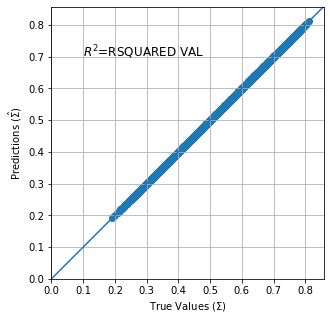

In [25]:
plt.figure(figsize=(5,5))
plt.grid(b=None)
plt.annotate(r'$R^2$=RSQUARED VAL',xy=(0.1, 0.7), fontsize=12)
plt.scatter(test_labelz, test_predictions)
plt.xlabel(r'True Values ($\Sigma$)')
plt.ylabel(r'Predictions ($\hat{\Sigma}$)')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Text(0, 0.5, 'Distribution')

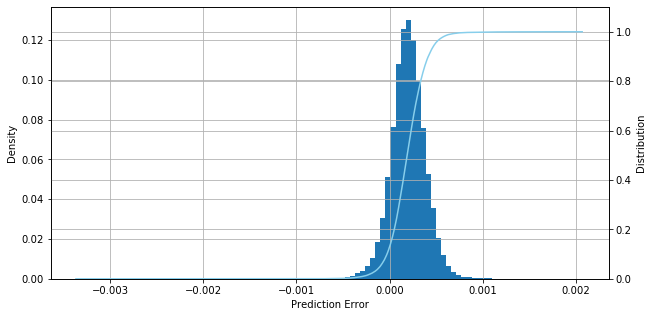

In [26]:
error = test_predictions - test_labelz

plt.figure(figsize=(10,5))
plt.grid(b=None)
plt.hist(x=error, bins=100, weights=np.zeros_like(error) + 1. / error.size)
#plt.xlim(-0.004, 0.004)
plt.xlabel("Prediction Error")
plt.ylabel("Density")
plt.twinx()
plt.grid(b=None)
# evaluate the histogram
values, base = np.histogram(error, bins=500)
#evaluate the cumulative
cumulative = np.cumsum(values)/100000
plt.plot(base[:-1], cumulative, color = "skyblue")
plt.ylim(0.0,1.1)
plt.ylabel("Distribution")

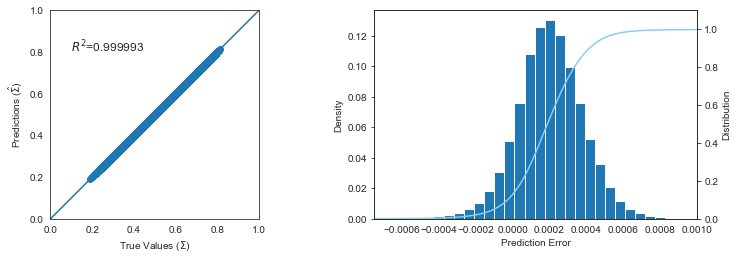

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
fig.tight_layout(pad=3.0)

ax1.annotate(r'$R^2$=0.999993',xy=(0.1, 0.8), fontsize=12)
ax1.scatter(test_labelz, test_predictions)
ax1.set_xlabel(r'True Values ($\Sigma$)')
ax1.set_ylabel(r'Predictions ($\hat{\Sigma}$)')
ax1.axis('equal')
ax1.axis('square')
ax1.set_xlim([0,plt.xlim()[1]])
ax1.set_ylim([0,plt.ylim()[1]])
_ = ax1.plot([-100, 100], [-100, 100])

ax2.hist(x=error, bins=100, weights=np.zeros_like(error) + 1. / error.size)
ax2.set_xlim(-0.00075,0.001)
ax2.set_xlabel("Prediction Error")
ax2.set_ylabel("Density")
ax3 = ax2.twinx()
# evaluate the histogram
values, base = np.histogram(error, bins=500)
#evaluate the cumulative
cumulative = np.cumsum(values)/100000
ax3.plot(base[:-1], cumulative, color = "skyblue")
ax3.set_ylim(0.0,1.1)
ax3.set_ylabel("Distribution")

#fig.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_dnn_diff_tight.png',bbox_inches='tight')

#### For the wide dataset:

In [28]:
losss, msee = model.evaluate(normed_test_data_wide, test_labels_wide, verbose=0)

print("Testing set Mean Squared Error: {:5.10f} imp vol".format(msee))

Testing set Mean Squared Error: 0.0000001500 imp vol


In [29]:
test_predictions_wide = model.predict(normed_test_data_wide).flatten(order="C")
test_labelz_wide = test_labels_wide.flatten(order="C")

r_squared(test_labelz_wide, test_predictions_wide)

0.9999897797687952

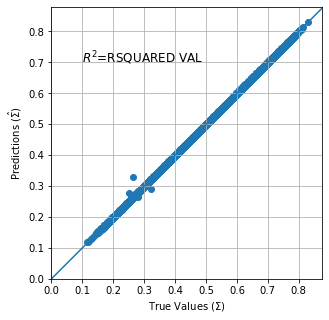

In [30]:
plt.figure(figsize=(5,5))
plt.annotate(r'$R^2$=RSQUARED VAL',xy=(0.1, 0.7), fontsize=12)
plt.grid(b=None)
plt.scatter(test_labelz_wide, test_predictions_wide)
plt.xlabel(r'True Values ($\Sigma$)')
plt.ylabel(r'Predictions ($\hat{\Sigma}$)')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

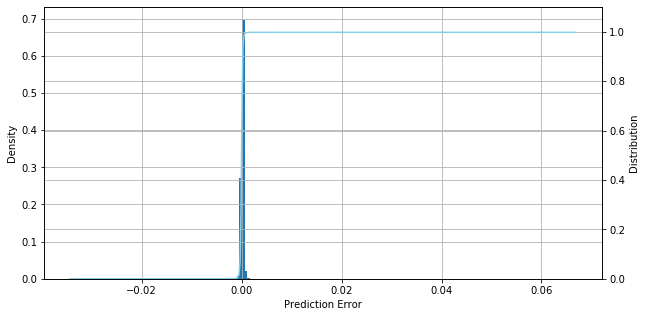

In [31]:
#Change the number of bins to change the look of the plot (make it look like the one for the small range test set but such that the error range is larger)

error_wide = test_predictions_wide - test_labelz_wide

plt.figure(figsize=(10,5))
plt.grid(b=None)
plt.hist(x=error_wide, bins=200, weights=np.zeros_like(error_wide) + 1. / error_wide.size)
#plt.xlim(-0.005, 0.005)
plt.xlabel("Prediction Error")
plt.ylabel("Density")
plt.twinx()
plt.grid(b=None)
# evaluate the histogram
values, base = np.histogram(error_wide, bins=500)
#evaluate the cumulative
cumulative = np.cumsum(values)/100000
plt.plot(base[:-1], cumulative, color = "skyblue")
plt.ylim(0.0,1.1)
plt.ylabel("Distribution");

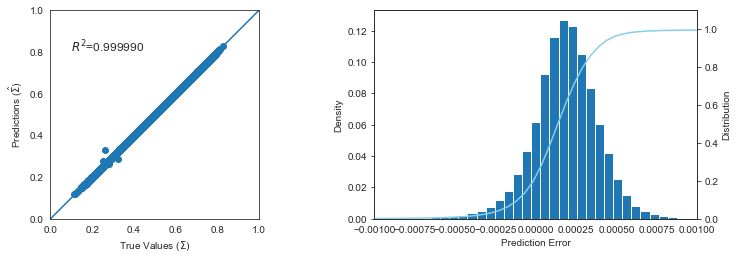

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
fig.tight_layout(pad=3.0)

ax1.annotate(r'$R^2$=0.999990',xy=(0.1, 0.8), fontsize=12)
ax1.scatter(test_labelz_wide, test_predictions_wide)
ax1.set_xlabel(r'True Values ($\Sigma$)')
ax1.set_ylabel(r'Predictions ($\hat{\Sigma}$)')
ax1.axis('equal')
ax1.axis('square')
ax1.set_xlim([0,plt.xlim()[1]])
ax1.set_ylim([0,plt.ylim()[1]])
_ = ax1.plot([-100, 100], [-100, 100])

ax2.hist(x=error_wide, bins=1800,weights=np.zeros_like(error_wide) + 1. / error_wide.size)
ax2.set_xlim(-0.001,0.001)
ax2.set_xlabel("Prediction Error")
ax2.set_ylabel("Density")
ax3 = ax2.twinx()
#ax2.grid(b=None)
# evaluate the histogram
values, base = np.histogram(error_wide, bins=2000)
#evaluate the cumulative
cumulative = np.cumsum(values)/100000
ax3.plot(base[:-1], cumulative, color = "skyblue")
ax3.set_ylim(0.0,1.1)
ax3.set_ylabel("Distribution")

#fig.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_dnn_diff_wide.png',bbox_inches='tight')

In [33]:
#plt.hist(x=error, bins=30, density=True);
#plt.hist(x=error, bins=30, cumulative=True)

Now, lets look at the distribution of the errors when looking at each of the 10 different strikes (NB, this only makes sence for the Heston model since we are dealing with fixed strikes).

### Smile error shown as a normal line chart

We here show a normal line-plot where we can see that the real analytic heston formula (red) and the ANN (blue) are almost identical

In [34]:
prediction_1 = model.predict(normed_test_data[1021:1022]).flatten() * 100
realprediction_1 = test_labels[1021:1022].flatten() * 100
Strikes = np.arange(0.5, 1.5, 0.1)

The input values that we use are

In [35]:
test_dataset[1021:1022]

,tau,r,sigma,rho,nu,theta,kappa
7625,0.54603,0.071281,0.128656,-0.670514,0.243811,0.262832,0.622491


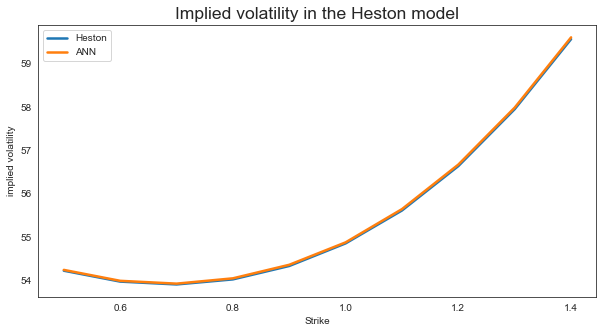

In [36]:
plt.figure(figsize=(10,5))
sns.set_style("white")
ax = sns.lineplot(x=Strikes, y=realprediction_1, color='#1f77b4', linewidth=2.5) #blue color
ax = sns.lineplot(x=Strikes, y=prediction_1, color='#ff7f0e', linewidth=2.5) #orange color
ax.axes.set_title("Implied volatility in the Heston model", fontsize=17.5);
ax.set(xlabel="Strike", ylabel="implied volatility")
ax.legend(['Heston', 'ANN']);

In [37]:
test_dataset[1013:1014]

,tau,r,sigma,rho,nu,theta,kappa
5923,0.353,0.063409,0.088732,-0.579519,0.139532,0.314623,1.838281


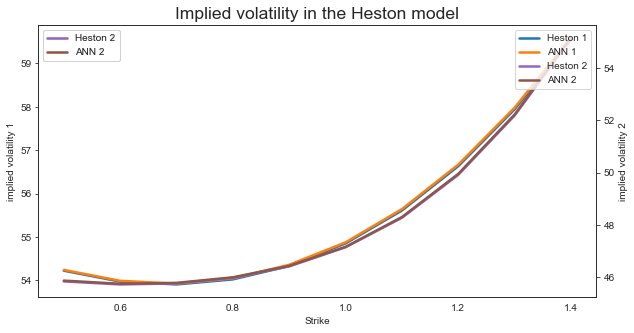

In [38]:
prediction_2 = model.predict(normed_test_data[1013:1014]).flatten() * 100
realprediction_2 = test_labels[1013:1014].flatten() * 100

fig = plt.figure(figsize=(10,5))
sns.set_style("white")
ax = sns.lineplot(x=Strikes, y=realprediction_1, color='#1f77b4', linewidth=2.5, label='Heston 1') #blue color
ax = sns.lineplot(x=Strikes, y=prediction_1, color='#ff7f0e', linewidth=2.5, label='ANN 1') #orange color
ax.axes.set_title("Implied volatility in the Heston model", fontsize=17.5);
ax.set(xlabel="Strike", ylabel="implied volatility 1")
ax1 = ax.twinx()
ax1 = sns.lineplot(x=Strikes, y=realprediction_2, color='#9467bd', linewidth=2.5, label='Heston 2') #blue color
ax1 = sns.lineplot(x=Strikes, y=prediction_2, color='#8c564b', linewidth=2.5,label='ANN 2') #orange color
ax1.set(xlabel="Strike", ylabel="implied volatility 2")
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

Lets just smooth the function by interpolating between our known values:

- https://www.kite.com/python/answers/how-to-plot-a-smooth-line-with-matplotlib-in-python
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html

In [39]:
from scipy.interpolate import CubicSpline
from tabulate import tabulate

In [40]:
print("Input data for (1):\n", tabulate(test_dataset[1021:1022]))
print("Input data for (2):", test_dataset[1013:1014])

Input data for (1):
 ----  -------  ---------  --------  ---------  --------  --------  --------
7625  0.54603  0.0712811  0.128656  -0.670514  0.243811  0.262832  0.622491
----  -------  ---------  --------  ---------  --------  --------  --------
Input data for (2):         tau         r     sigma       rho        nu     theta     kappa
5923  0.353  0.063409  0.088732 -0.579519  0.139532  0.314623  1.838281


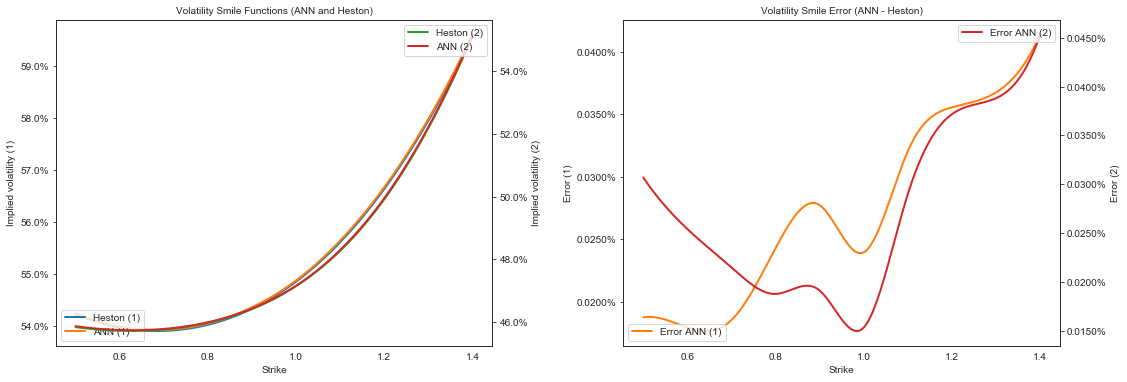

In [41]:
#increase the steps in the strike range
x_new = np.linspace(min(Strikes), max(Strikes), 1000)

# interpolation for the predicted outputs
Spline_1 = CubicSpline(Strikes, prediction_1)
Spline_2 = CubicSpline(Strikes, prediction_2)
y_1 = Spline_1(x_new)
y_2 = Spline_2(x_new)

#interpolation for the real output
Spline_r1 = CubicSpline(Strikes, realprediction_1)
Spline_r2 = CubicSpline(Strikes, realprediction_2)
y_r1 = Spline_r1(x_new)
y_r2 = Spline_r2(x_new)

#volatility smile error
y1_error = y_1 - y_r1
y2_error= y_2 - y_r2


#The plot itself
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
fig.subplots_adjust(wspace=0.3)
sns.set_style("white")

sns.lineplot(x=x_new, y=y_r1, color='#1f77b4', linewidth=2., ax=ax1, label='Heston (1)')
sns.lineplot(x=x_new, y=y_1, color='#ff7f0e', linewidth=2., ax=ax1, label='ANN (1)')
ax1.axes.set_title("Volatility Smile Functions (ANN and Heston)", fontsize=10)
ax1.set(xlabel="Strike", ylabel="Implied volatility (1)")
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.legend(loc="lower left")
ax11 = ax1.twinx()
sns.lineplot(x=x_new, y=y_r2, color='#2ca02c', linewidth=2., ax=ax11, label='Heston (2)')
sns.lineplot(x=x_new, y=y_2, color='#d62728', linewidth=2., ax=ax11, label='ANN (2)')
ax11.set(ylabel='Implied volatility (2)')
ax11.yaxis.set_major_formatter(mtick.PercentFormatter())
ax11.legend(loc="upper right")

sns.lineplot(x=x_new, y=y1_error, color='#ff7f0e', linewidth=2., ax=ax2, label='Error ANN (1)')
ax2.axes.set_title("Volatility Smile Error (ANN - Heston)", fontsize=10)
ax2.set(xlabel="Strike", ylabel="Error (1)")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.legend(loc="lower left")
ax22 = ax2.twinx()
sns.lineplot(x=x_new, y=y2_error, color='#d62728', linewidth=2., ax=ax22, label='Error ANN (2)')
ax22.set(ylabel="Error (2)")
ax22.yaxis.set_major_formatter(mtick.PercentFormatter())
ax22.legend(loc="upper right")

#fig.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_smiles.png',bbox_inches='tight')

## **CDF and PDF**

- https://machinelearningmastery.com/statistical-data-distributions/
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.cdf.html
- https://stackoverflow.com/questions/24788200/calculate-the-cumulative-distribution-function-cdf-in-python
- https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html
- https://en.wikipedia.org/wiki/Finite_difference


In order to find the PDF (and from that the CDF) we will use the Breeden and Litzenberger formula. Also, to compute the first and second derivative of the pdf we will use numerical differentiation.

$\textbf{PDF}$: 
A probability density function (PDF), or density of a continuous random variable, is a function whose value at any given sample (or point) in the sample space (the set of possible values taken by the random variable) can be interpreted as providing a relative likelihood that the value of the random variable would equal that sample. In other words, while the absolute likelihood for a continuous random variable to take on any particular value is 0 (since there are an infinite set of possible values to begin with), the value of the PDF at two different samples can be used to infer, in any particular draw of the random variable, how much more likely it is that the random variable would equal one sample compared to the other sample.

In a more precise sense, the PDF is used to specify the probability of the random variable falling within a particular range of values, as opposed to taking on any one value. This probability is given by the integral of this variable's PDF over that range—that is, it is given by the area under the density function but above the horizontal axis and between the lowest and greatest values of the range. The probability density function is nonnegative everywhere, and its integral over the entire space is equal to 1.

$$
f(X)=\frac{d(F(x))}{dx}
$$

$\textbf{CDF}$: 
The cumulative distribution function (CDF) of a real-valued random variable X, or just distribution function of X, evaluated at x, is the probability that X will take a value less than or equal to x.

In the case of a scalar continuous distribution, it gives the area under the probability density function from minus infinity to x. 

$$
F(X)=\int_{0}^{x}f(s) \qquad \text{where s is a dummy integration variable}
$$

In [42]:
from scipy.integrate import quad
from scipy.stats import norm

In [43]:
data_outputs = test_dataset[2001:2002]
data_outputs

,tau,r,sigma,rho,nu,theta,kappa
10113,0.279977,0.014641,0.183633,-0.306657,0.23508,0.203872,1.217487


In [44]:
pred_cdfpdf = model.predict(normed_test_data[2001:2002]).flatten()
real_cdfpdf = test_labels[2001:2002].flatten()
K_cdfpdf = np.arange(0.5, 1.5, 0.1)
inputs_data = (data_outputs.values).flatten()

#plt.plot(K_cdfpdf, pred_cdfpdf);

interpolate the strikes and implied volatility

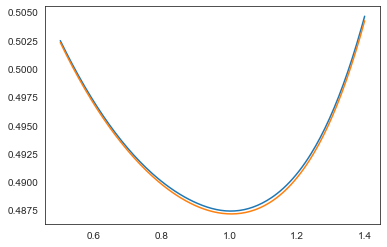

In [45]:
x = np.linspace(min(K_cdfpdf), max(K_cdfpdf), 200)

cs = CubicSpline(K_cdfpdf, pred_cdfpdf)
# y= interpolated imp vol predictions
y = cs(x)

cs_real = CubicSpline(K_cdfpdf, real_cdfpdf)
# y_real = interpolated real imp vol
y_real = cs_real(x)
plt.plot(x, y);
plt.plot(x,y_real)

In order to calculate the probability density function, we will use the Breeden and Litzenberger formula:
$$
f_Q(X_T)=e^{r\tau}\frac{\partial C_{BS}(X_T)}{\partial X_T^2}\approx e^{r\tau}\frac{C(K+\Delta_K,T)-2C(K,T)+C(K-\Delta_K,T)}{(\Delta_K)^2}
$$

We will therefore calculate the BSM call prices using the above strikes and implied volatilities

In [46]:
def euro_vanilla(S_t, K, t, T, r, sigma, option = ''):
    d1 = (np.log(S_t/K)+(r+0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))
    d2 = (np.log(S_t/K)+(r-0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))
    
    if option == 'call':
        result = S_t*norm.cdf(d1, 0.0, 1.0)-K*np.exp(-r*(T-t))*norm.cdf(d2, 0.0, 1.0)
    if option == 'put':
        result = K*np.exp(-r*(T-t))*norm.cdf(-d2, 0.0, 1.0)-S_t*norm.cdf(-d1, 0.0, 1.0)
    
    return result

In [47]:
#inputs: 
S = 1.
t = 0.
tau = (data_outputs.values).flatten()[0]
r = (data_outputs.values).flatten()[1]

call_pred = []
call_real = []
for i in range(len(x)):
    BSM_pred = euro_vanilla(S_t=S, K=x[i], t=t, T=tau, r=r, sigma=y[i], option = 'call')
    call_pred.append(BSM_pred)
    
    BSM_real = euro_vanilla(S_t=S, K=x[i], t=t, T=tau, r=r, sigma=y_real[i], option = 'call')
    call_real.append(BSM_real)

Now we will use the above breeden litzenberger formula

In [48]:
pdf_pred = []
pdf_real = []
for i in range(1,len(x)-1):
    PDF_pred = np.exp(r*tau) * (call_pred[i+1] - 2*call_pred[i] + call_pred[i-1]) / ((x[i+1] - x[i])**2)
    pdf_pred.append(PDF_pred)
    
    PDF_real = np.exp(r*tau) * (call_real[i+1] - 2*call_real[i] + call_real[i-1]) / ((x[i+1] - x[i])**2)
    pdf_real.append(PDF_real)

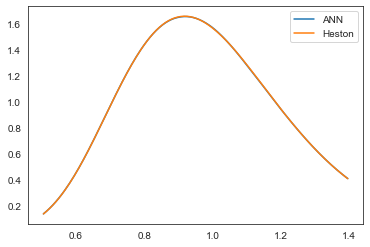

In [49]:
plt.plot(x[1:199],pdf_pred)
plt.plot(x[1:199],pdf_real)
plt.legend(['ANN', 'Heston'])

In [50]:
len(pdf_pred)

198

And for the CDF we simply do the following: 

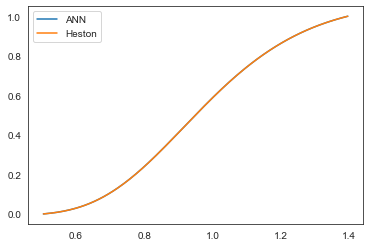

In [51]:
cdf_pred = np.cumsum(pdf_pred) / np.sum(pdf_pred)
cdf_real = np.cumsum(pdf_real) / np.sum(pdf_real)
plt.plot(x[1:199], cdf_pred)
plt.plot(x[1:199], cdf_real)
plt.legend(['ANN', 'Heston'])

Now we calculate the percent error (in terms of the ANN and the true Heston model) of the smile, the PDF and the CDF

In [52]:
#Smile error
smile_error = y - y_real
#plt.plot(x, smile_error)

#CDF error
cdf_error = cdf_pred-cdf_real
#plt.plot(x[1:199],cdf_error)

#PDF error
pdf_error = np.asarray(pdf_pred) - np.asarray(pdf_real)
#plt.plot(x[1:199],pdf_error)

In [53]:
'''
If we want to se what the min, max, mean, variance, skewness, kurtosis is
''';
from scipy import stats
#stats.describe(smile_error)
#stats.describe(cdf_error)
#stats.describe(pdf_error)

Collect it all and plot it such that it looks like McGhees work on page 17

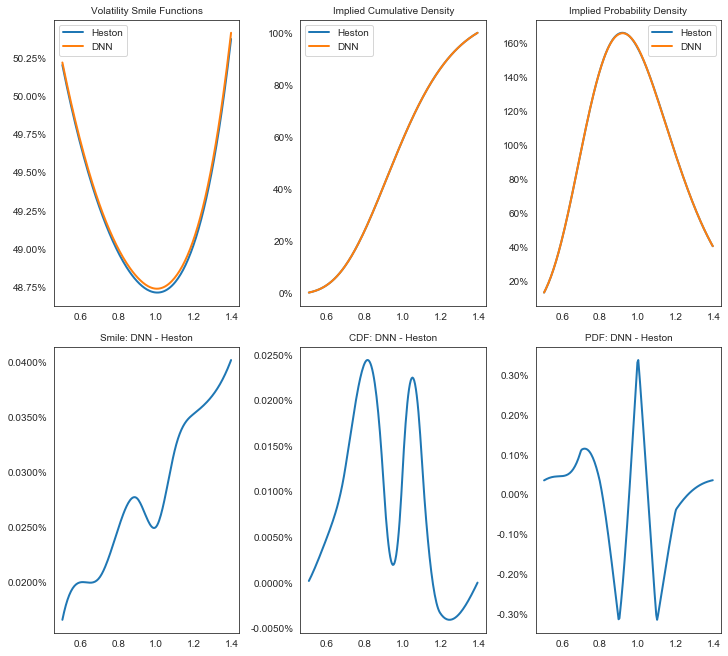

In [54]:
fig, axs = plt.subplots(2, 3, figsize=(10,9), constrained_layout=True)
sns.set_style("white")

sns.lineplot(x=x[1:199], y=y_real[1:199]*100, color='#1f77b4', linewidth=2., ax=axs[0,0])
sns.lineplot(x=x[1:199], y=y[1:199]*100, color='#ff7f0e', linewidth=2., ax=axs[0,0])
axs[0,0].axes.set_title("Volatility Smile Functions", fontsize=10)
#ax1.set(xlabel="Strike", ylabel="Implied volatility")
axs[0,0].yaxis.set_major_formatter(mtick.PercentFormatter())
axs[0,0].legend(['Heston', 'DNN']);

sns.lineplot(x=x[1:199], y=cdf_real*100, color='#1f77b4', linewidth=2., ax=axs[0,1])
sns.lineplot(x=x[1:199], y=cdf_pred*100, color='#ff7f0e', linewidth=2., ax=axs[0,1])
axs[0,1].axes.set_title("Implied Cumulative Density", fontsize=10)
#ax2.set(xlabel="Strike", ylabel="Error")
axs[0,1].yaxis.set_major_formatter(mtick.PercentFormatter())
axs[0,1].legend(['Heston', 'DNN'])

sns.lineplot(x=x[1:199], y=np.asarray(pdf_real)*100, color='#1f77b4', linewidth=2., ax=axs[0,2])
sns.lineplot(x=x[1:199], y=np.asarray(pdf_pred)*100, color='#ff7f0e', linewidth=2., ax=axs[0,2])
axs[0,2].axes.set_title("Implied Probability Density", fontsize=10)
#ax2.set(xlabel="Strike", ylabel="Error")
axs[0,2].yaxis.set_major_formatter(mtick.PercentFormatter())
axs[0,2].legend(['Heston', 'DNN'])

sns.lineplot(x=x[1:199], y=smile_error[1:199]*100, color='#1f77b4', linewidth=2., ax=axs[1,0])
axs[1,0].axes.set_title("Smile: DNN - Heston", fontsize=10)
axs[1,0].yaxis.set_major_formatter(mtick.PercentFormatter())

sns.lineplot(x=x[1:199], y=cdf_error*100, color='#1f77b4', linewidth=2., ax=axs[1,1])
axs[1,1].axes.set_title("CDF: DNN - Heston", fontsize=10)
axs[1,1].yaxis.set_major_formatter(mtick.PercentFormatter())

sns.lineplot(x=x[1:199], y=pdf_error*100, color='#1f77b4', linewidth=2., ax=axs[1,2])
axs[1,2].axes.set_title("PDF: DNN - Heston", fontsize=10)
axs[1,2].yaxis.set_major_formatter(mtick.PercentFormatter())

#fig.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_cdfpdf_deep.png',bbox_inches='tight')

### Percent deviation of errors boxplot

In [55]:
Strikes

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4])

In [56]:
# MSE for the test_data
prediction_mse = np.subtract(model.predict(normed_test_data),test_labels)

# Percent deviation from the true data aka test_labels
percent_deviation = pd.DataFrame(np.subtract(model.predict(normed_test_data),test_labels)*100)
#percent_deviation = pd.DataFrame(np.divide(np.subtract(model.predict(normed_test_data),test_labels),test_labels)*100)
percent_deviation = percent_deviation.rename(columns={0: 'K1=0.50', 1: 'K2=0.60', 2: 'K3=0.70', 3: 'K4=0.80', 4: 'K5=0.90', 5: 'K6=1.00', 6: 'K7=1.10',
                                                       7: 'K8=1.20', 8: 'K9=1.30', 9: 'K10=1.40'})

In [57]:
df = pd.DataFrame(percent_deviation)
print("The lowest mean squared error for each strike:\n", df.min())
print("\nThe highest mean squared error for each strike:\n", df.max())
#print(prediction_mse.max())

The lowest mean squared error for each strike:
 K1=0.50    -0.336510
K2=0.60    -0.073257
K3=0.70    -0.073713
K4=0.80    -0.079459
K5=0.90    -0.075352
K6=1.00    -0.100410
K7=1.10    -0.073266
K8=1.20    -0.101835
K9=1.30    -0.129074
K10=1.40   -0.182039
dtype: float64

The highest mean squared error for each strike:
 K1=0.50     0.166279
K2=0.60     0.075650
K3=0.70     0.083095
K4=0.80     0.087672
K5=0.90     0.082010
K6=1.00     0.068206
K7=1.10     0.094038
K8=1.20     0.177638
K9=1.30     0.133461
K10=1.40    0.207844
dtype: float64


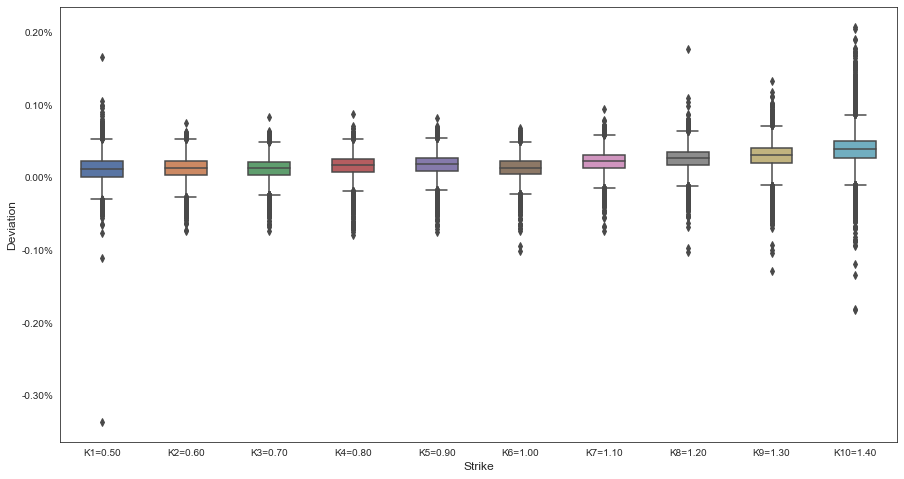

In [112]:
fig, ax = plt.subplots(figsize=(15,8))

sns.set_style("whitegrid") 

sns.boxplot(data=percent_deviation, ax=ax, palette="deep",
           width=0.5)

ax.set_xlabel('Strike', fontsize=12)
ax.set_ylabel('Deviation', fontsize=12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
#ax.set_title('Predicted values percent deviation from actual values', fontsize=20);
#sns.despine(left=True) #removes the lines to the left and right

#fig.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_boxplot_deep.png',bbox_inches='tight')

Excluding the outliers, we get:

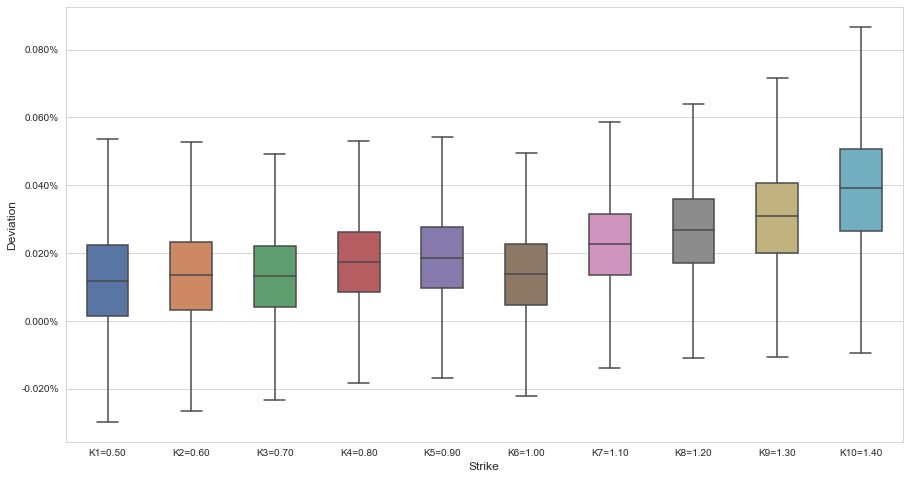

In [59]:
fig, ax = plt.subplots(figsize=(15,8))

sns.set_style("whitegrid") 

sns.boxplot(data=percent_deviation, ax=ax, palette="deep",
           width=0.5, showfliers=False)

ax.set_xlabel('Strike', fontsize=12)
ax.set_ylabel('Deviation', fontsize=12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())


**Interpreting the boxplot:**

Boxplot is a chart that is used to visualize how a given data (variable) is distributed using quartiles. It shows the minimum, maximum, median, first quartile and third quartile in the data set. Let’s take the first box plot i.e, blue box plot of the figure and understand these statistics:
- Bottom black horizontal line of blue box plot is minimum value 
- First black horizontal line of rectangle shape of blue box plot is First quartile or 25%
- Second black horizontal line of rectangle shape of blue box plot is Second quartile or 50% or median
- Third black horizontal line of rectangle shape of blue box plot is third quartile or 75%
- Top black horizontal line of rectangle shape of blue box plot is maximum value.
- Small diamond shape of blue box plot is outlier data or erroneous data

The negative outlies signifies that the predicted implied volatilities is lower than the actual implied volatilities. The positive ourliers signifies that the predicted implied volatilities is higher than the actual implied volatilities.

### Percent deviation of errors scatterplot

In [60]:
test_dataset_tau = []
test_dataset_r = []
test_dataset_sigma = []
test_dataset_rho = []
test_dataset_nu = []
test_dataset_theta = []
test_dataset_kappa = []

for i in range(10):
    test_dataset_tau.append(test_dataset['tau'])
    test_dataset_r.append(test_dataset['r'])
    test_dataset_sigma.append(test_dataset['sigma'])
    test_dataset_rho.append(test_dataset['rho'])
    test_dataset_nu.append(test_dataset['nu'])
    test_dataset_theta.append(test_dataset['theta'])
    test_dataset_kappa.append(test_dataset['kappa'])
    

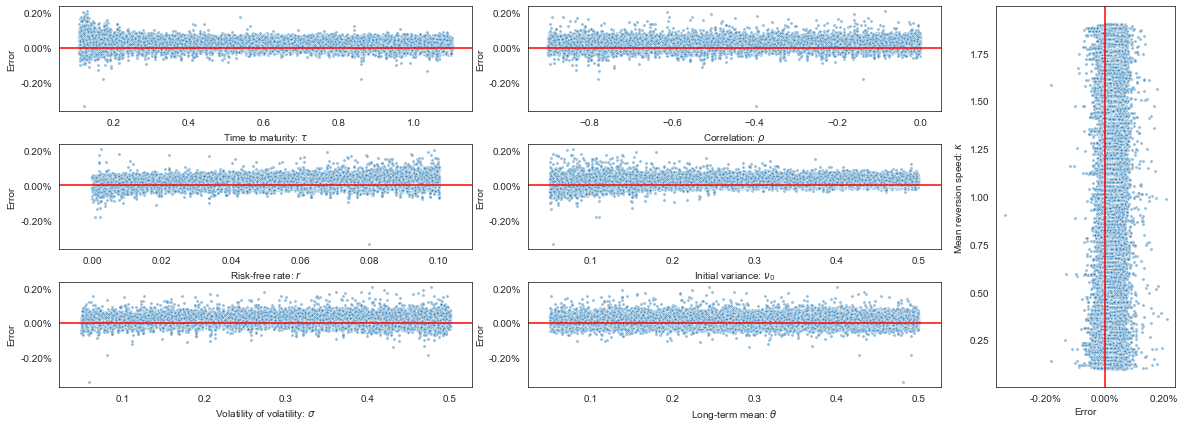

In [61]:
fig = plt.figure(figsize=(20, 7))
gs = fig.add_gridspec(6, 10, wspace=0.9, hspace=0.9)
sns.set_style("white")

ax0 = plt.subplot(gs[0:2,0:4])
ax0.set_ylabel("Error")
ax0.set_xlabel(r"Time to maturity: $\tau$")
ax0.axhline(linewidth=1.5, color='r')
ax0.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.scatterplot(x=np.array(test_dataset_tau).flatten(), y=(percent_deviation.values).flatten(order='F'), ax=ax0,
                color = '#1f77b4',  alpha=0.5, s=10)

ax1 = plt.subplot(gs[2:4,0:4])
ax1.set_ylabel("Error")
ax1.set_xlabel(r"Risk-free rate: $r$")
ax1.axhline(linewidth=1.5, color='r')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.scatterplot(x=np.array(test_dataset_r).flatten(), y=(percent_deviation.values).flatten(order='F'), ax=ax1,
                color = '#1f77b4',  alpha=0.5, s=10)

ax2 = plt.subplot(gs[4:6,0:4])
ax2.set_ylabel("Error")
ax2.set_xlabel(r"Volatility of volatility: $\sigma$")
ax2.axhline(linewidth=1.5, color='r')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.scatterplot(x=np.array(test_dataset_sigma).flatten(), y=(percent_deviation.values).flatten(order='F'), ax=ax2,
                color = '#1f77b4',  alpha=0.5, s=10)

ax3 = plt.subplot(gs[0:2,4:8])
ax3.set_ylabel("Error")
ax3.set_xlabel(r"Correlation: $\rho$")
ax3.axhline(linewidth=1.5, color='r')
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.scatterplot(x=np.array(test_dataset_rho).flatten(), y=(percent_deviation.values).flatten(order='F'), ax=ax3,
                color = '#1f77b4',  alpha=0.5, s=10)

ax4 = plt.subplot(gs[2:4,4:8])
ax4.set_ylabel("Error")
ax4.set_xlabel(r"Initial variance: $\nu_0$")
ax4.axhline(linewidth=1.5, color='r')
ax4.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.scatterplot(x=np.array(test_dataset_nu).flatten(), y=(percent_deviation.values).flatten(order='F'), ax=ax4,
                color = '#1f77b4',  alpha=0.5, s=10)

ax5 = plt.subplot(gs[4:6,4:8])
ax5.set_ylabel("Error")
ax5.set_xlabel(r"Long-term mean: $\theta$")
ax5.axhline(linewidth=1.5, color='r')
ax5.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.scatterplot(x=np.array(test_dataset_theta).flatten(), y=(percent_deviation.values).flatten(), ax=ax5,
                color = '#1f77b4',  alpha=0.5, s=10)

ax6 = plt.subplot(gs[0:6,8:10])
ax6.set_xlabel("Error")
ax6.set_ylabel(r"Mean reversion speed: $\kappa$")
ax6.axvline(linewidth=1.5, color='r')
ax6.xaxis.set_major_formatter(mtick.PercentFormatter())
sns.scatterplot(x=(percent_deviation.values).flatten(), y=np.array(test_dataset_kappa).flatten(order='F'), ax=ax6,
               color = '#1f77b4',  alpha=0.5, s=10);

#fig.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_scatterplot.png',bbox_inches='tight')

### Volatility surface (Strike, implied vol, time to maturity)
- https://matplotlib.org/3.1.1/gallery/mplot3d/surface3d.html
- https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
- https://towardsdatascience.com/an-easy-introduction-to-3d-plotting-with-matplotlib-801561999725
- https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html

In [113]:
Heatmap_input = pd.read_csv (r"/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_data_input_heatmap.csv")
Heatmap_output = pd.read_csv (r"/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_data_output_heatmap.csv")
del Heatmap_input['Unnamed: 0']
del Heatmap_output['Unnamed: 0']

normed_Heatmap_input = norm_test(Heatmap_input).values
Heatmap_output = np.asarray(Heatmap_output)


Heatmap_predict = model.predict(normed_Heatmap_input).flatten(order="C")
Heatmap_predictz = model.predict(normed_Heatmap_input)
Heatmap_outputz = Heatmap_output.flatten(order="C")

Heatmap_error = Heatmap_predict - Heatmap_outputz

In [114]:
#len(Heatmap_predict)
moneyness = np.tile(np.arange(0.5, 1.5, 0.1),100)
tau = np.tile(np.linspace(0.5, 1.0, 100),10)

In [115]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

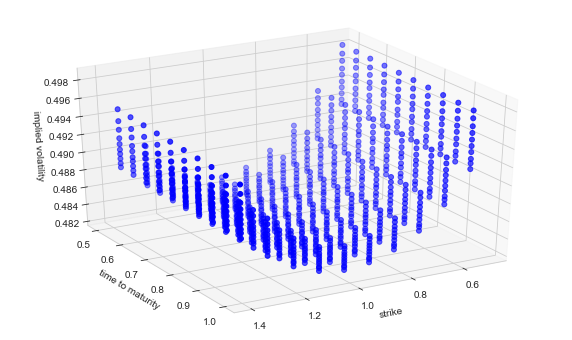

In [116]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30,60)
ax.scatter(moneyness, tau, Heatmap_predict, zdir='z', s=25, c='b', marker='o')
ax.set_facecolor('xkcd:white')
ax.set_xlabel('strike')
ax.set_ylabel('time to maturity')
ax.set_zlabel('implied volatility');


In [126]:
#Heatmap_predictz.shape
#moneynessz.shape
#tauz.shape

#type(tauz)
#type(Heatmap_predictz)
#type(moneynessz)

numpy.ndarray

In [189]:
%matplotlib notebook

<IPython.core.display.Javascript object>


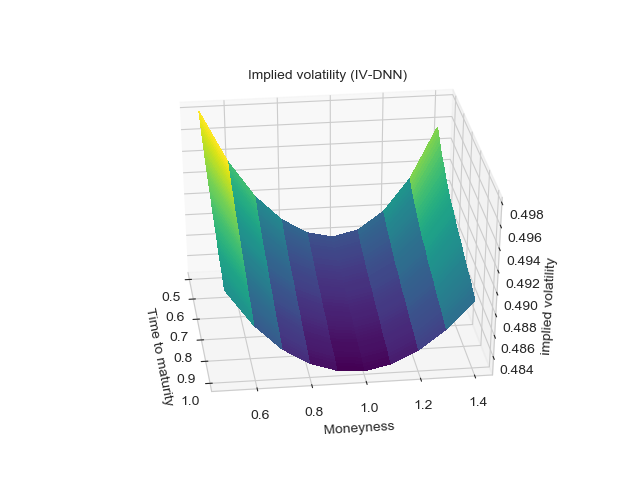

In [191]:
#every axis needs to be the same shape

moneynessz = np.arange(0.5, 1.5, 0.1)
tauz = np.linspace(0.5, 1.0, 100) #the way it is chosen in the data set. 
moneynessz, tauz = np.meshgrid(moneynessz, tauz)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(tauz, moneynessz, Heatmap_predictz, cmap='viridis', edgecolor='none', linewidth=0, antialiased=False)
ax.set_xlabel('Time to maturity')
ax.set_ylabel('Moneyness')
ax.set_zlabel('implied volatility');

In [138]:
#fig.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_vol_surface.png',bbox_inches='tight')

### Contour plot of error (Strike, implied vol, time to maturity)
- https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
- https://www.oreilly.com/library/view/python-data-science/9781491912126/ch04.html
- https://jakevdp.github.io/PythonDataScienceHandbook/

In [192]:
%matplotlib inline

In [174]:
Heatmap_errorz = Heatmap_predictz - Heatmap_output

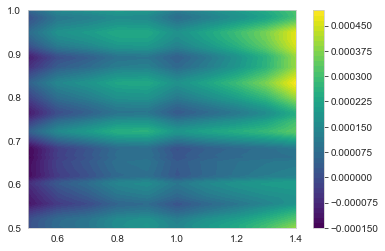

In [205]:
plt.contourf(moneynessz, tauz, Heatmap_errorz, 50, cmap='viridis')#vmin=-0.00015, vmax=0.00045
plt.colorbar();

#plt.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_contourp.png',bbox_inches='tight')

### Heatmap of error (Strike, implied vol, time to maturity)

- https://seaborn.pydata.org/generated/seaborn.heatmap.html
- https://chartio.com/learn/charts/heatmap-complete-guide/#:~:text=When%20you%20should%20use%20a,for%20one%20or%20both%20variables.
- https://likegeeks.com/seaborn-heatmap-tutorial/


does it even make sence to create a heatmap?

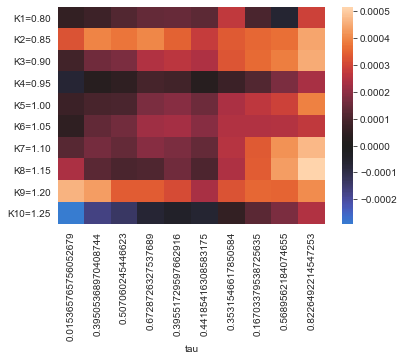

In [67]:
Strikes = ['K1=0.80', 'K2=0.85', 'K3=0.90', 'K4=0.95', 'K5=1.00', 'K6=1.05', 'K7=1.10', 'K8=1.15', 'K9=1.20', 'K10=1.25']
normed_test_data_labled = pd.DataFrame(data=normed_test_data, columns=["tau", "r", "sigma", "rho", "nu", "theta", "kappa"])
TTM = normed_test_data_labled["tau"][:10]
Heatmap_data = prediction_mse.copy()[:10]

Heatmap = pd.DataFrame(Heatmap_data, index=Strikes, columns=TTM)
Heatmap.sort_index(axis=1, ascending=True)
sns.heatmap(Heatmap, center=0)

In [152]:
Heatmap_data.shape

(10, 10)

## **OPTIMAL CHOICE OF LAYERS**

We have already run and saved the output of the different runs in an excel sheet. We will quickly convert it to a pandas dataframe

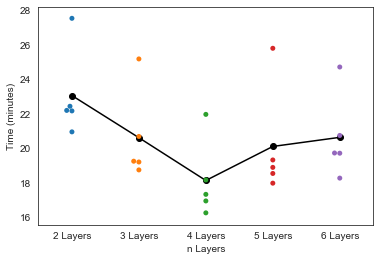

In [68]:
# data
layers_time = {'2 Layers': [22.4360, 27.5285, 22.1958, 20.9536, 22.1673],
               '3 Layers': [20.6885, 25.1765, 18.7503, 19.2090, 19.2548],
               '4 Layers': [18.1703, 21.9665, 16.9536, 17.3353, 16.2638],
               '5 Layers': [19.3265, 25.7931, 17.9827, 18.5448, 18.8970],
               '6 Layers': [19.7180, 24.7097, 20.7460, 19.7300, 18.2760]
                }
cols = ['2 Layers', '3 Layers', '4 Layers', '5 Layers', '6 Layers']
df = pd.DataFrame(layers_time, columns = cols)

# columns means evaluation
means = df.mean(axis = 0).to_list()

# dataframe reshaping
df = pd.melt(frame = df,
             var_name = 'n Layers',
             value_name = 'Time (minutes)')

# figure set-up
fig, ax = plt.subplots()
sns.set_style("white")

# mean plot
ax.plot(cols, means, color = 'black', marker = 'o', linestyle = '-')

# dot-plot
sns.swarmplot(ax = ax,
              data = df,
              x = 'n Layers',
              y = 'Time (minutes)')

# show figure
plt.show()

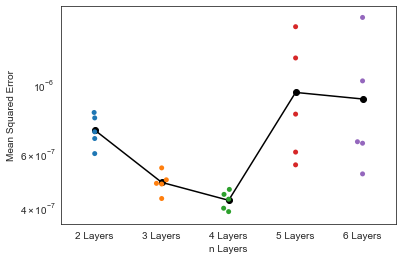

In [69]:
# data
layers_mse = {'2 Layers': [0.00000078373, 0.00000067204, 0.00000081617, 0.00000070649, 0.00000060061],
               '3 Layers': [0.00000049383, 0.000000481, 0.00000042956, 0.00000047862, 0.00000053981],
               '4 Layers': [0.00000045975, 0.00000038955, 0.00000039954, 0.00000044306, 0.00000042742],
               '5 Layers': [0.0000015478, 0.00000055221, 0.0000008063, 0.0000012258, 0.00000060738],
               '6 Layers': [0.00000065616, 0.00000064889, 0.00000051614, 0.0000016585, 0.0000010331]
                } 
cols_mse = ['2 Layers', '3 Layers', '4 Layers', '5 Layers', '6 Layers']
df_mse = pd.DataFrame(layers_mse, columns = cols_mse)


# columns means evaluation
means_mse = df_mse.mean(axis = 0).to_list()

# dataframe reshaping
df_mse = pd.melt(frame = df_mse,
             var_name = 'n Layers',
             value_name = 'Mean Squared Error')

# figure set-up
fig, ax = plt.subplots()
sns.set_style("white")

# mean plot
ax.plot(cols_mse, means_mse, color = 'black', marker = 'o', linestyle = '-')

# dot-plot
sns.swarmplot(ax = ax,
              data = df_mse,
              x = 'n Layers',
              y = 'Mean Squared Error')
ax.set_yscale("log")

# show figure
plt.show()

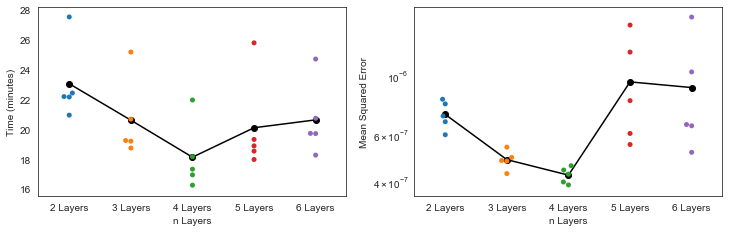

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
fig.tight_layout(pad=4.0)


ax1.plot(cols, means, color = 'black', marker = 'o', linestyle = '-')
sns.swarmplot(ax = ax1,
              data = df,
              x = 'n Layers',
              y = 'Time (minutes)')


ax2.plot(cols_mse, means_mse, color = 'black', marker = 'o', linestyle = '-')
sns.swarmplot(ax = ax2,
              data = df_mse,
              x = 'n Layers',
              y = 'Mean Squared Error')
ax2.set_yscale("log")

#fig.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_depthtime.png',bbox_inches='tight')

## **SPEED PERFORMANCE**

Lets test how fast our model is at predicting vs just calculating using the standard Heston way. 
We start with the model prediction time

Inspirations:
- https://stackoverflow.com/questions/60267911/keras-inconsistent-prediction-time
- https://serverfault.com/questions/48455/what-are-the-differences-between-wall-clock-time-user-time-and-cpu-time#:~:text=In%20contrast%20to%20CPU%20time,for%20resources%20to%20become%20available. (model.predict(input) seems slower than model(input))

### Heston neural network

We run the test on our test dataset which contains (10000,7) datapoints i.e. 10000 smiles or 100000 implied volatilities

In [72]:
%%timeit
model(normed_test_data)

152 ms ± 24.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
%%timeit
model.predict(normed_test_data)

449 ms ± 58.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


predicting using "model" is the fastest and takes 41.7 milliseconds (0.0417 sec) which is 0.00000417 sec per smile and 0.000000417 (4.17e^-7) sec per volatility

### Heston analytic model

Now, lets calculate the time it takes to run 1 implied vol but on our standard heston model (using the analytic method). Instead of running the Heston imp vol code in python, we will use C++ to get a more justifiable comparison. We will here include a picture of the resulting output.

In [74]:
from IPython.display import Image

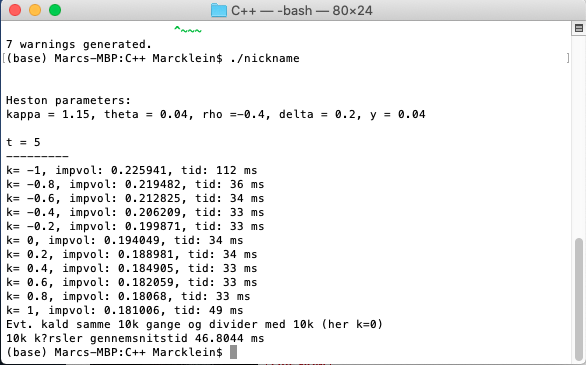

In [75]:
Image("/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_cpp.png")

Calculating 1 implied volatility using the simple heston model takes 46.8044microseconds (4.68044e^-5). Calculating one smile takes  4.680443^-5*10= 4.680443^-4sec

**Result:**

This means that the ANN is 0.0000468044/0.000000417=112,2407673861 times faster than the normal Heston calculator

## **NOTES/TRIALS FOR LATER USE**

- save and load keras model: https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [76]:
'''#log our training in order to display it to tensorboard (provides great visual effects)
NAME = "Heston_Tensorboard-{}".format(int(time.time()))
tensorboard_callback = TensorBoard(log_dir="logs/fit/{}".format(NAME),  
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    update_freq="epoch",
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None)''';